In [144]:
import pandas as pd
import pandas_datareader as pdr

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns

from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics import tsaplots as tsp
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from sklearn import mixture as mxt

from sklearn.model_selection import TimeSeriesSplit

from scipy import stats as scpSta
from scipy.stats import ks_2samp

import ffn
import pyfolio as pf

import warnings
warnings.filterwarnings("ignore")


#### Getting the returns in % for the daily adjusted close. Later on we can look at the Drawdown based on the same

In [64]:
def get_stock(indx,start,end):
    
        dataF = pdr.get_data_tiingo(indx, start, end, api_key='b7a9706daf700d3eafed86f85a5ff0273864f149')['adjClose'].reset_index(0,drop=True)
    
        return dataF

    
indx = ['SPY', 'QQQ', 'TLT', 'GLD', 'EFA', 'EEM']

end = pd.to_datetime('2018-12-31')
start = end - 20 * 252 * pd.tseries.offsets.BDay()


    
prices_df = (pd.DataFrame.from_dict({sym: get_stock(sym,start,end) for sym in indx}))

prices_df.dropna(inplace=True)

prices_df = prices_df.loc[~(prices_df==0).all(axis=1)]

prices_df

,SPY,QQQ,TLT,GLD,EFA,EEM
date,,,,,,
2004-11-18 00:00:00+00:00,85.846526,34.248755,52.239291,44.38,32.360158,15.593663
2004-11-19 00:00:00+00:00,84.892194,33.717023,51.822410,44.78,32.150639,15.370722
2004-11-22 00:00:00+00:00,85.297066,34.039549,52.092502,44.95,32.244923,15.430714
2004-11-23 00:00:00+00:00,85.427203,33.987248,52.157090,44.75,32.307778,15.457466
2004-11-24 00:00:00+00:00,85.629636,34.283623,52.157090,45.05,32.454441,15.622037
...,...,...,...,...,...,...
2018-12-24 00:00:00+00:00,225.693205,141.320689,116.661402,120.02,53.785897,36.491108
2018-12-26 00:00:00+00:00,237.096327,150.144615,115.411321,119.66,55.033874,37.217870
2018-12-27 00:00:00+00:00,238.916589,150.725655,115.430553,120.57,55.194598,37.170057


#### Looking at the overall % change in returns we can see the evident crash of 2008

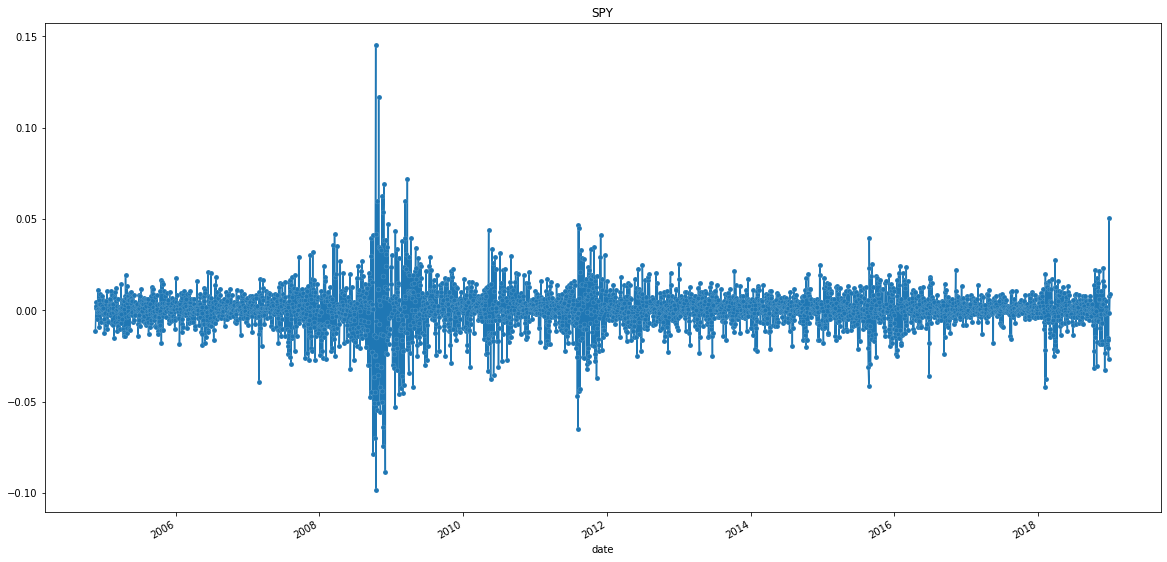

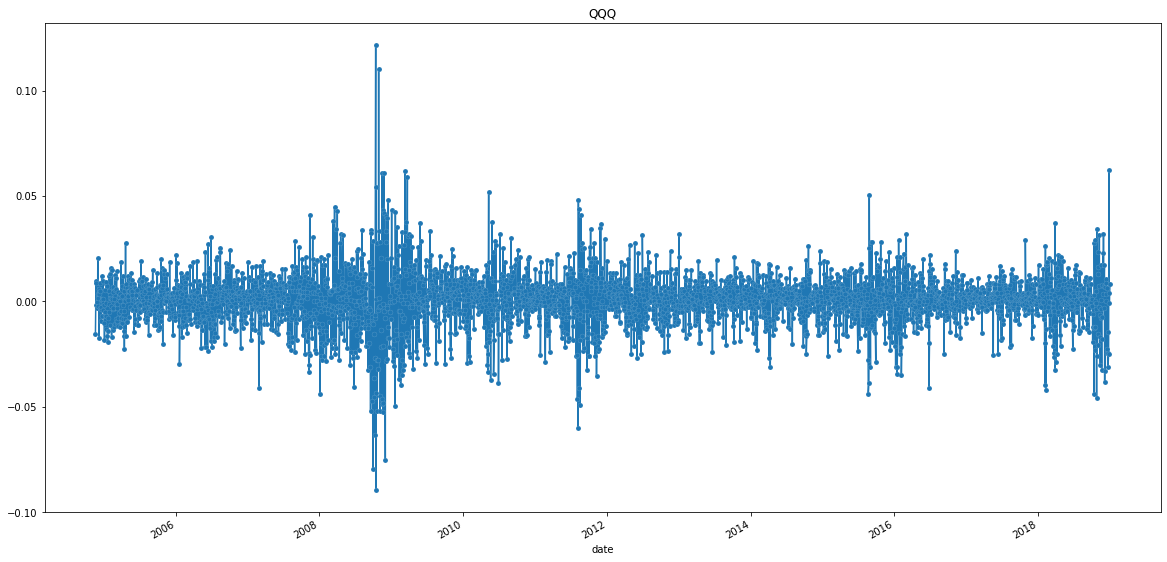

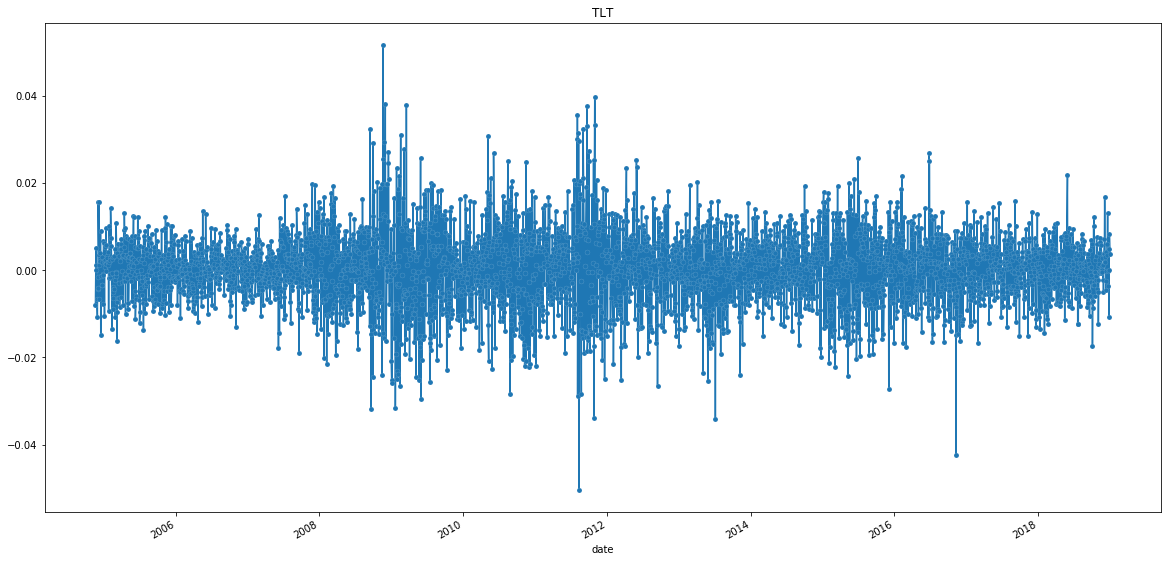

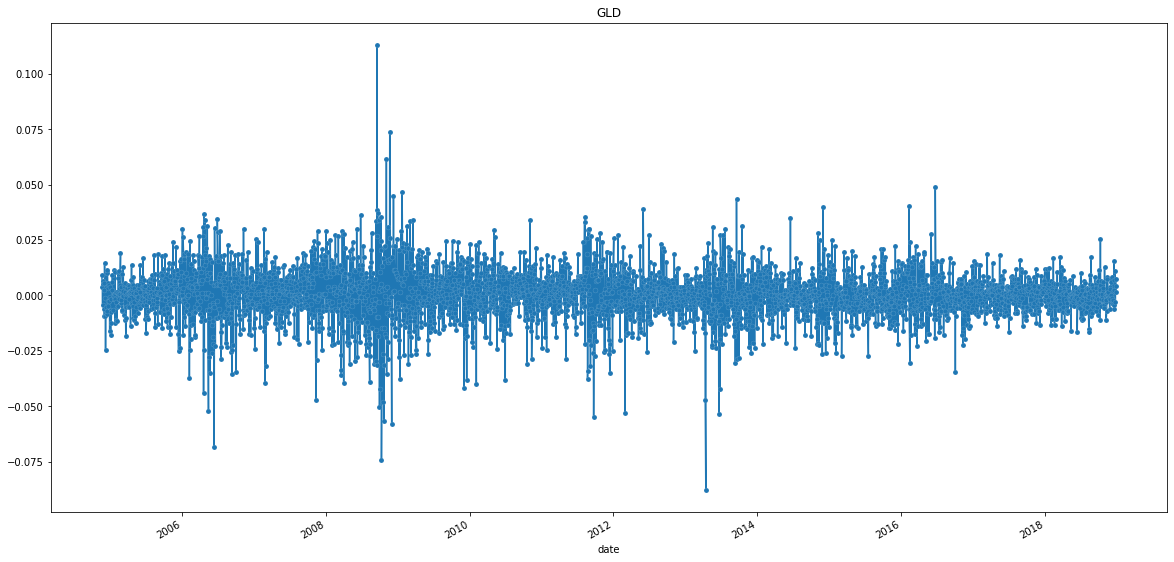

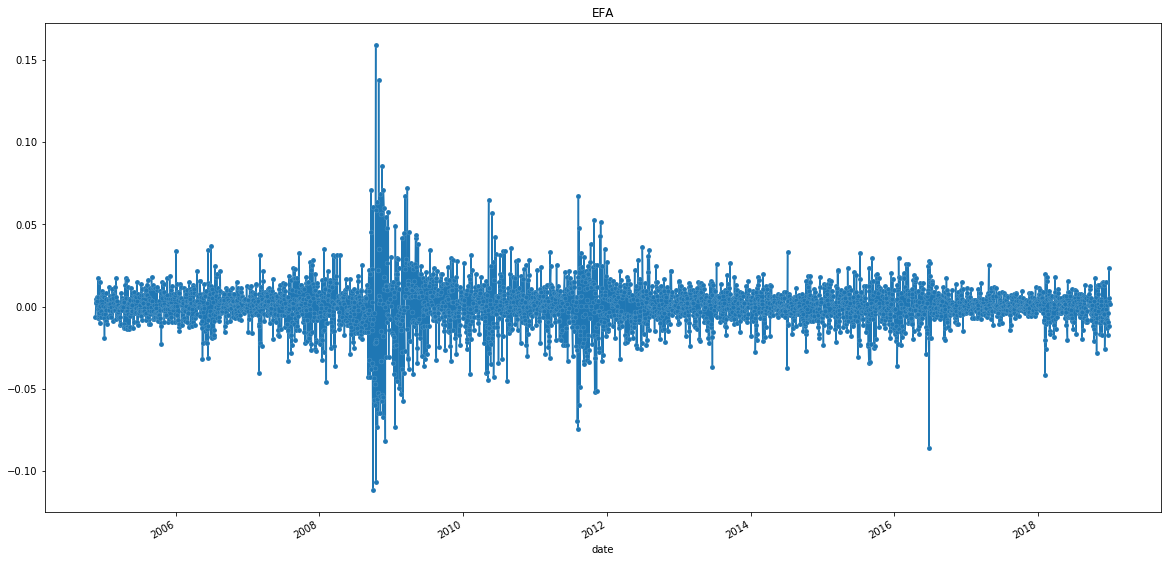

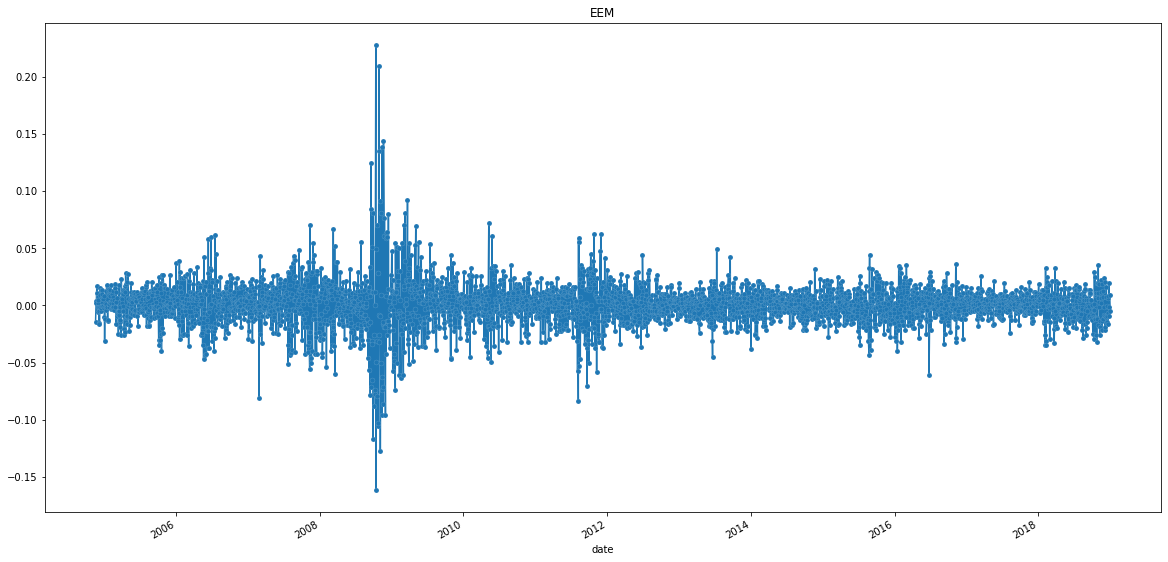

In [4]:
R0 = (prices_df.pct_change()).dropna()

for cols in R0.columns:
    fig, ax0 = plt.subplots(figsize=(20,10))
    R0[cols].plot(ax=ax0,marker='o', ms=5.,markeredgecolor='white', markeredgewidth=.1,title=cols)   
    

ADF = -12.938768451956218
p-value = 0.00000
ADF = -14.551200094124933
p-value = 0.00000
ADF = -28.786662632795313
p-value = 0.00000
ADF = -61.010479447617406
p-value = 0.00000
ADF = -12.957476313033366
p-value = 0.00000
ADF = -13.301328344983911
p-value = 0.00000
ADF = -0.8614121743552465
p-value = 0.80041


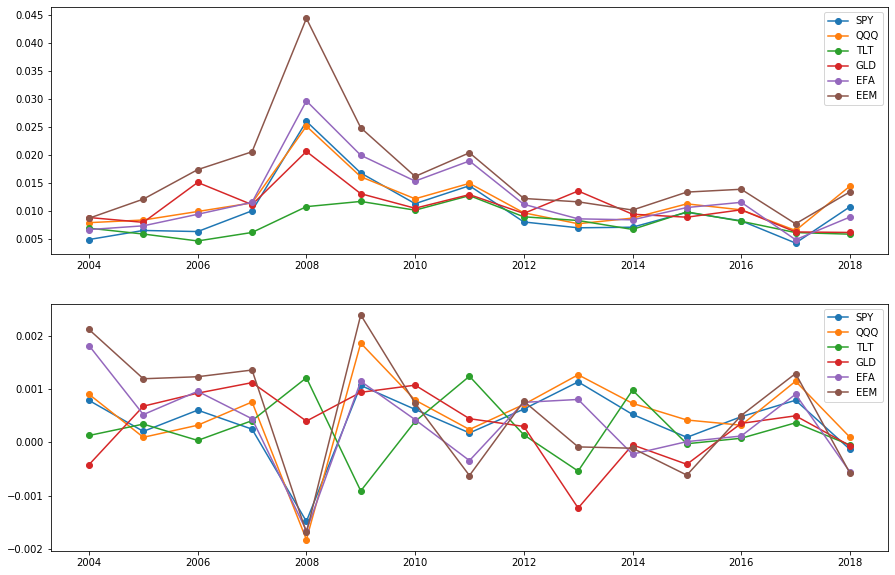

In [5]:
R0['year'] = R0.index.year
def plotStd(data):
    fig, (ax1,ax2) = plt.subplots(figsize=(15,10),nrows=2)
    ax1.plot(data.groupby(data['year']).std(),marker="o",label='Std Dev')
    ax2.plot(data.groupby(data['year']).mean(),marker="o",label='Mean')
    ax1.legend(data)
    ax2.legend(data)

for cols in R0.columns:
        adf_test = adfuller(R0[cols])
        print("ADF = " + str(adf_test[0]))
        print("p-value = " + str('%.5f'%adf_test[1]))
    
plotStd(R0)


#### Making the columns stationary for normality constraint  

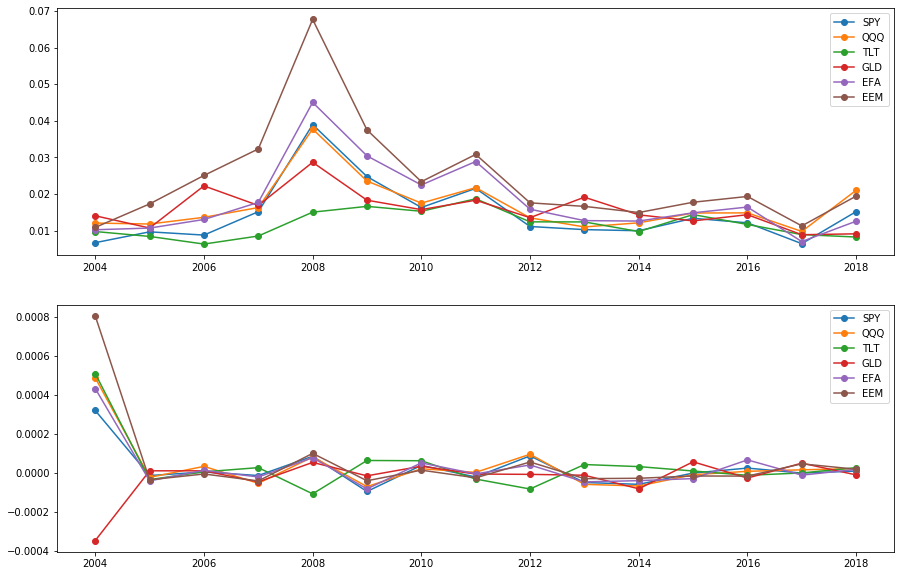

In [6]:
R = R0[:-1].diff(periods=1)
R.dropna(inplace=True)
R['year'] = R.index.year

plotStd(R)

#### Analysing the data distribution for the return indices yearwise

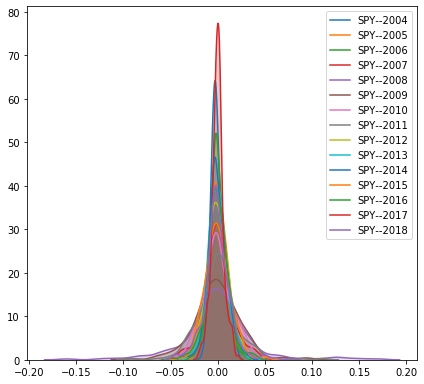

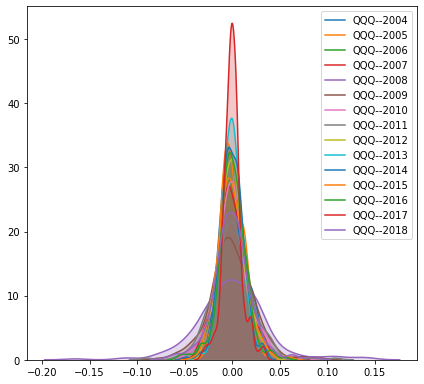

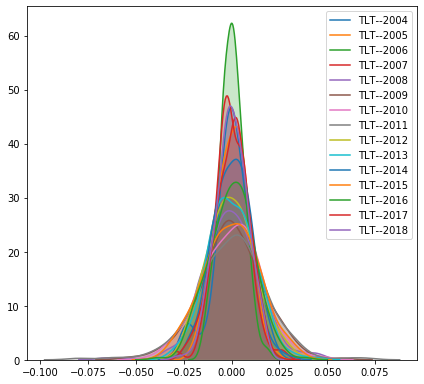

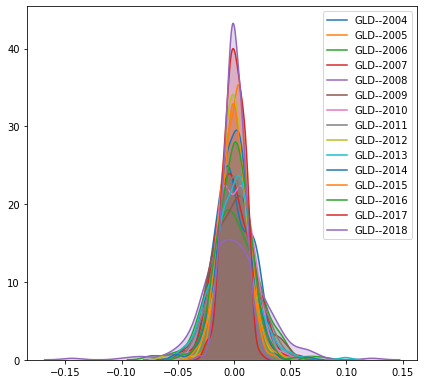

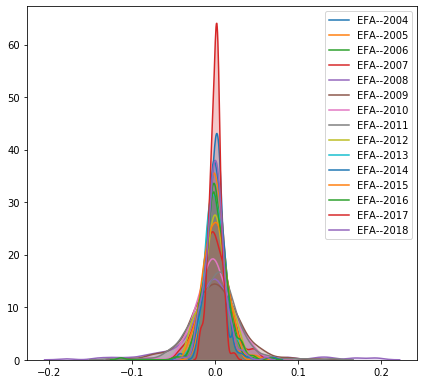

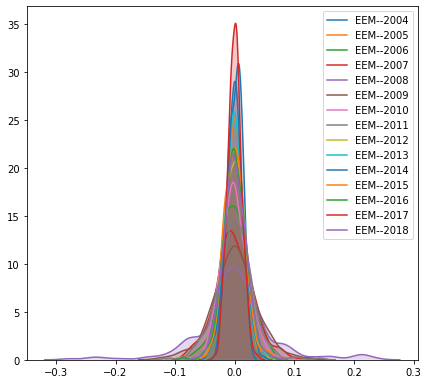

In [7]:
for cols in R.columns[:-1]:
    fig, ax = plt.subplots(figsize=(7,6.5))
    for year in R['year'].unique():    
        sns.kdeplot(R[cols][R['year']==year],shade=True,label=str(cols) + '--' + str(year))

#### Testing the unit root with Dicky Fuller and correlation test

In [8]:
for cols in R.columns:
        adf_test = adfuller(R[cols])
        print("ADF = " + str(adf_test[0]))
        print("p-value = " + str('%.5f'%adf_test[1]))

ADF = -19.232938405080358
p-value = 0.00000
ADF = -18.851456303021784
p-value = 0.00000
ADF = -18.54958488559478
p-value = 0.00000
ADF = -18.234184252055453
p-value = 0.00000
ADF = -19.989045774530865
p-value = 0.00000
ADF = -19.55965427881562
p-value = 0.00000
ADF = -0.8621179859201504
p-value = 0.80019


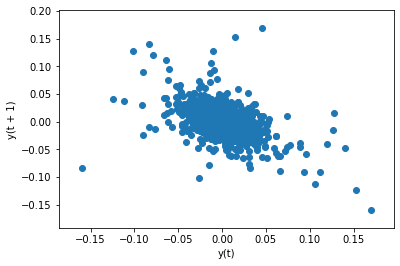

In [9]:
pd.plotting.lag_plot(R['SPY'])

#### Testing the Partial autocorrelation and autocorrelation

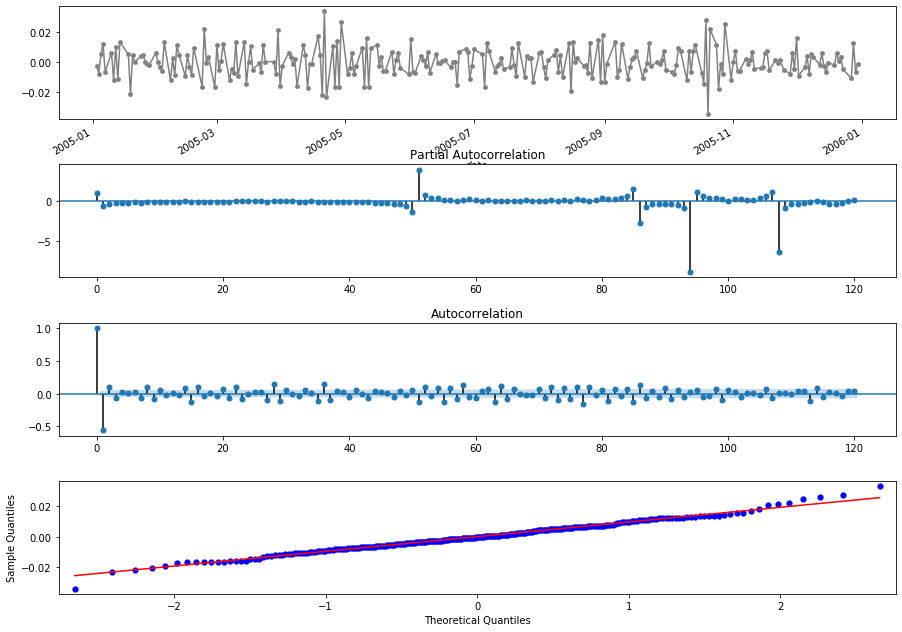

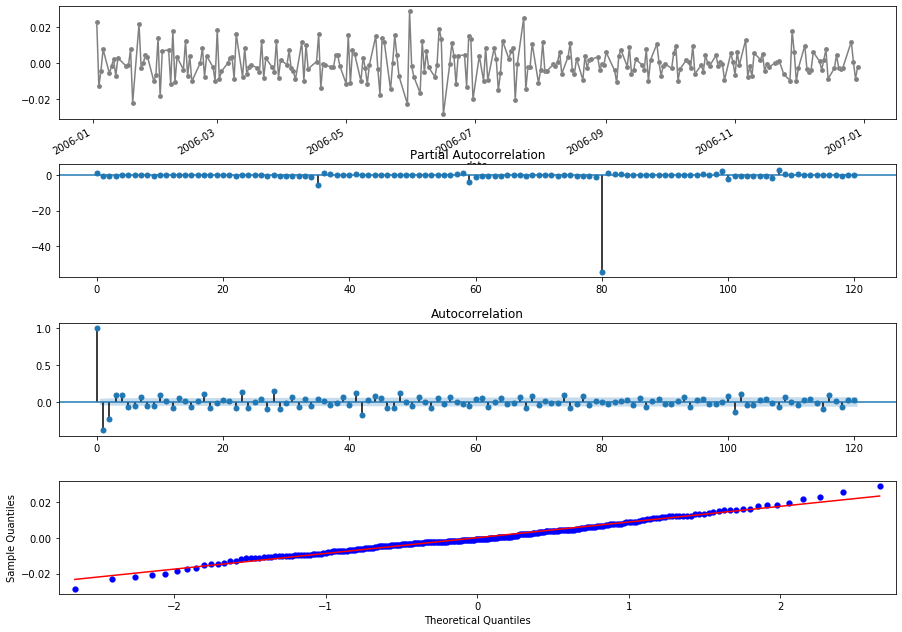

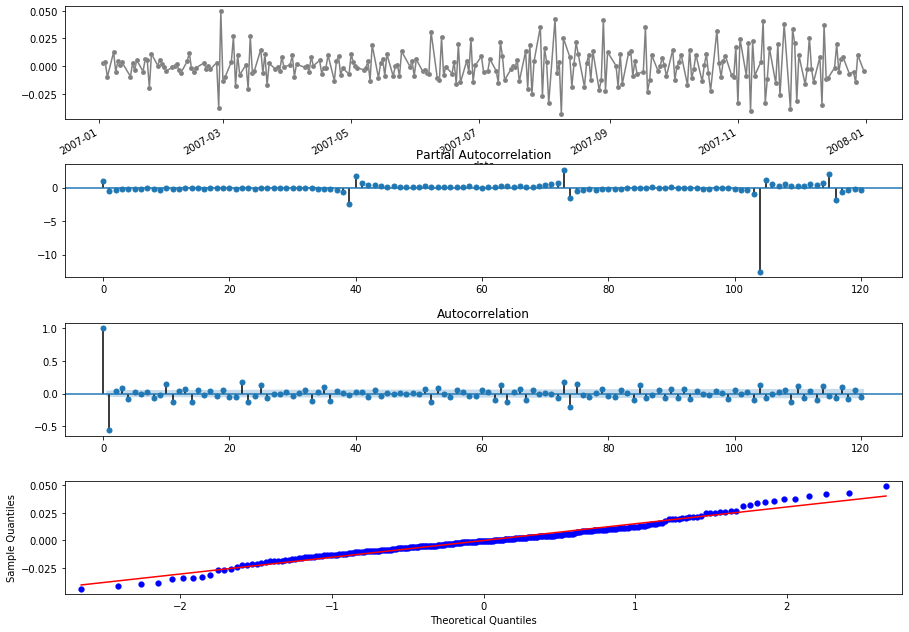

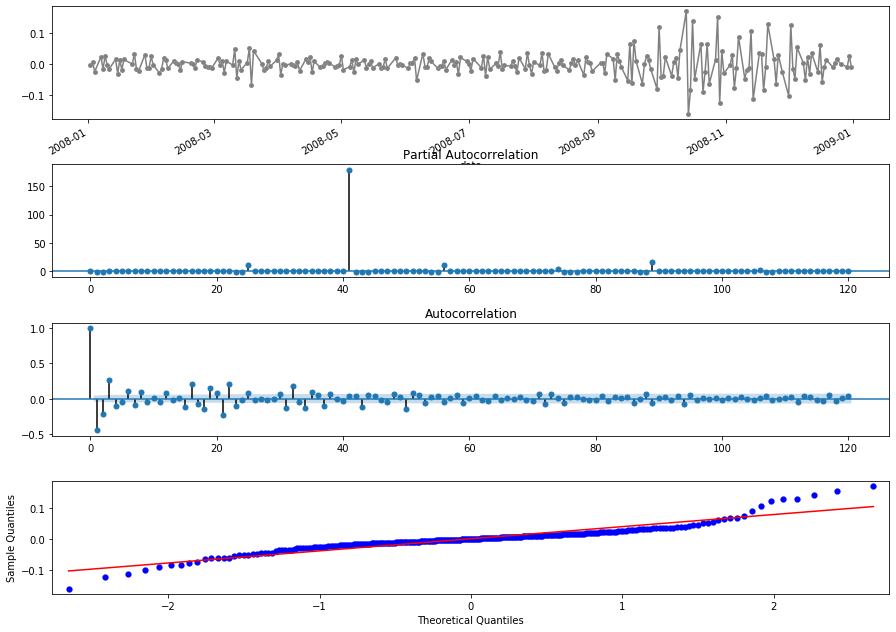

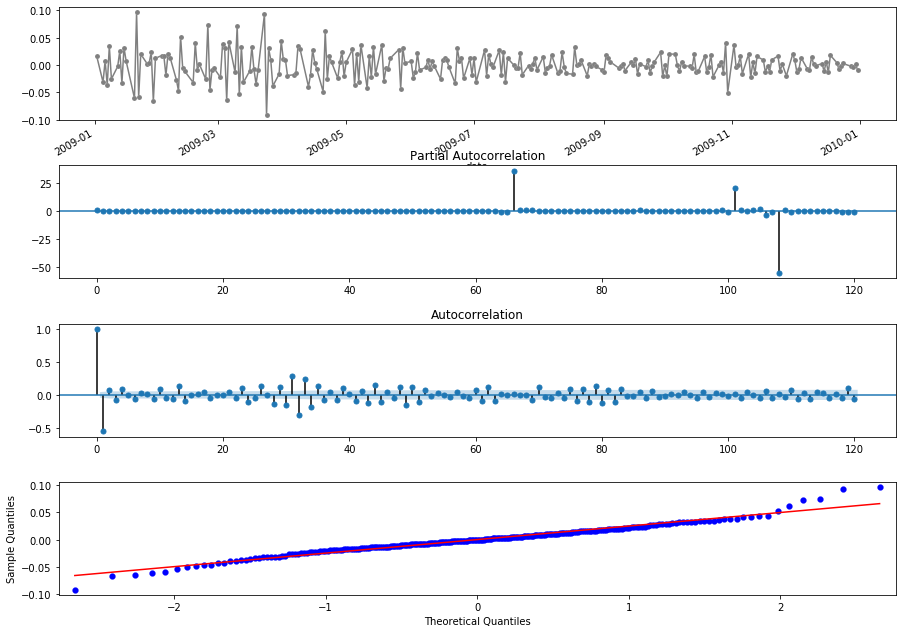

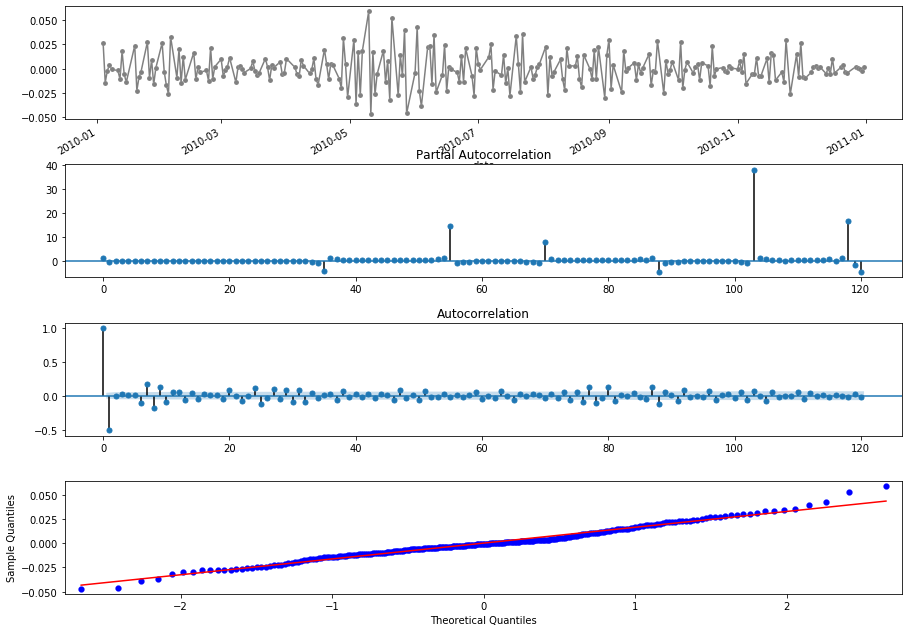

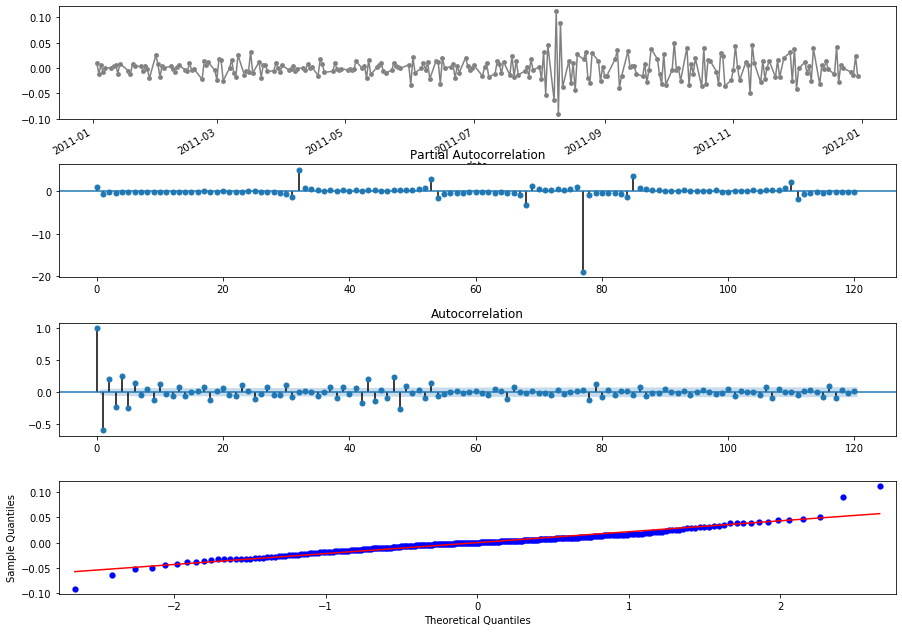

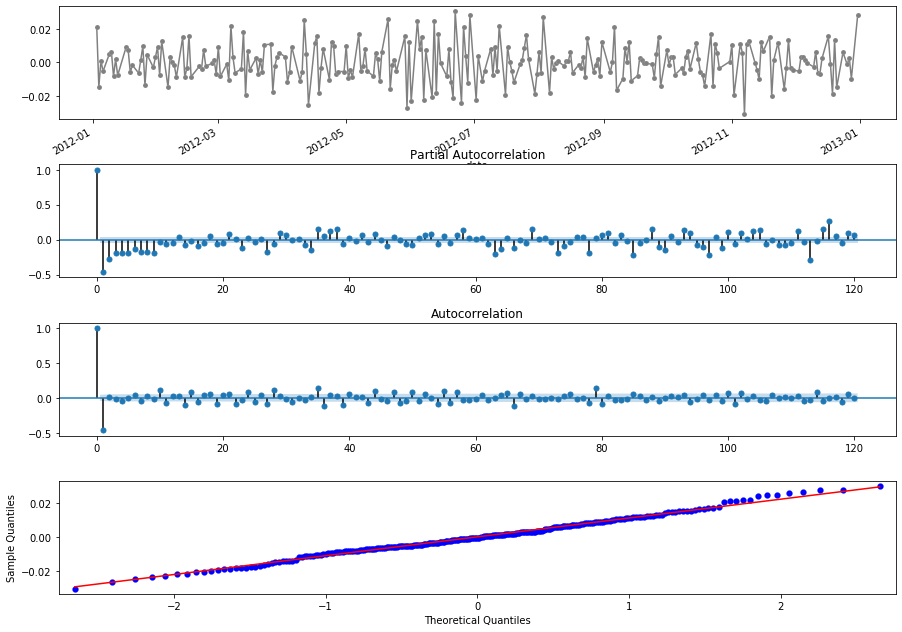

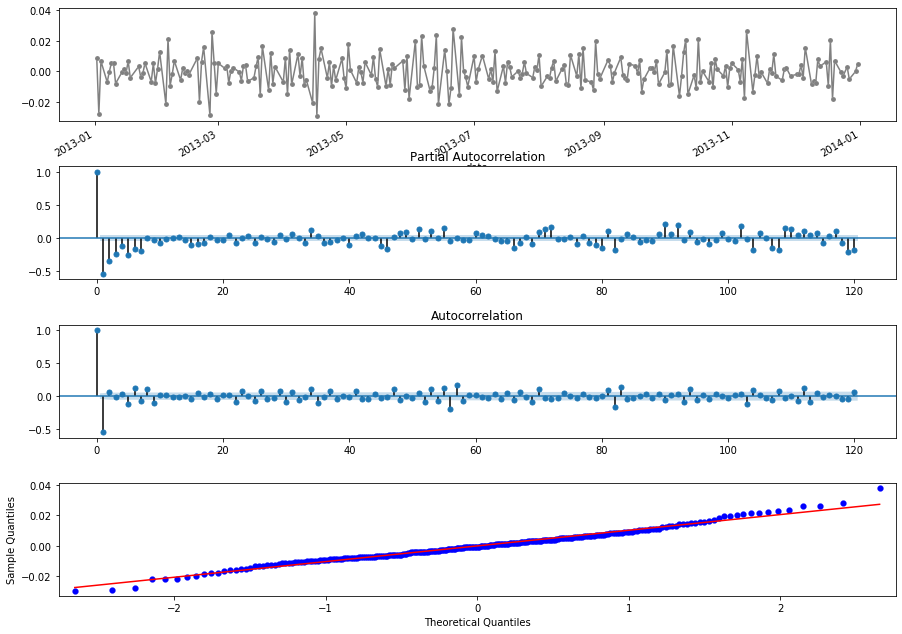

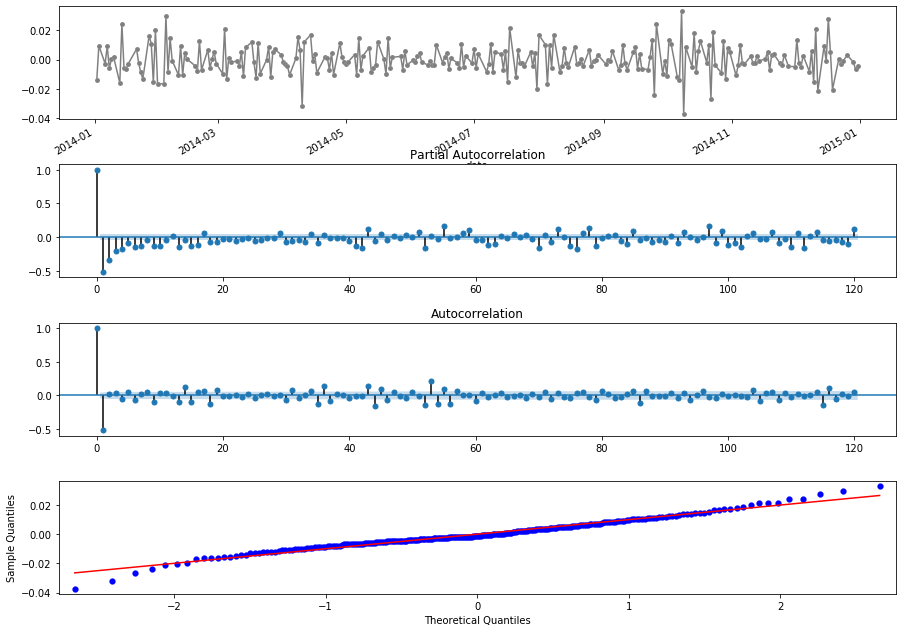

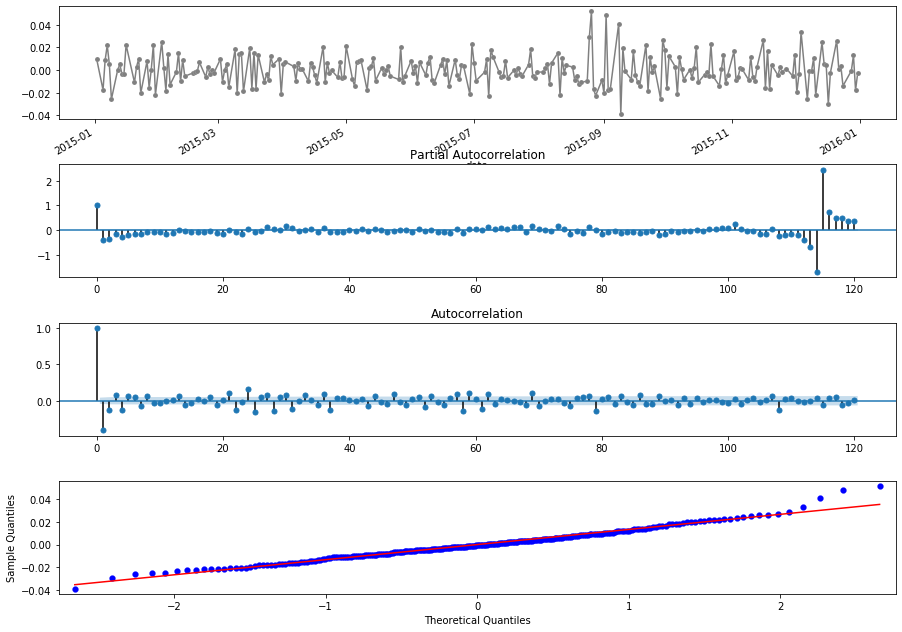

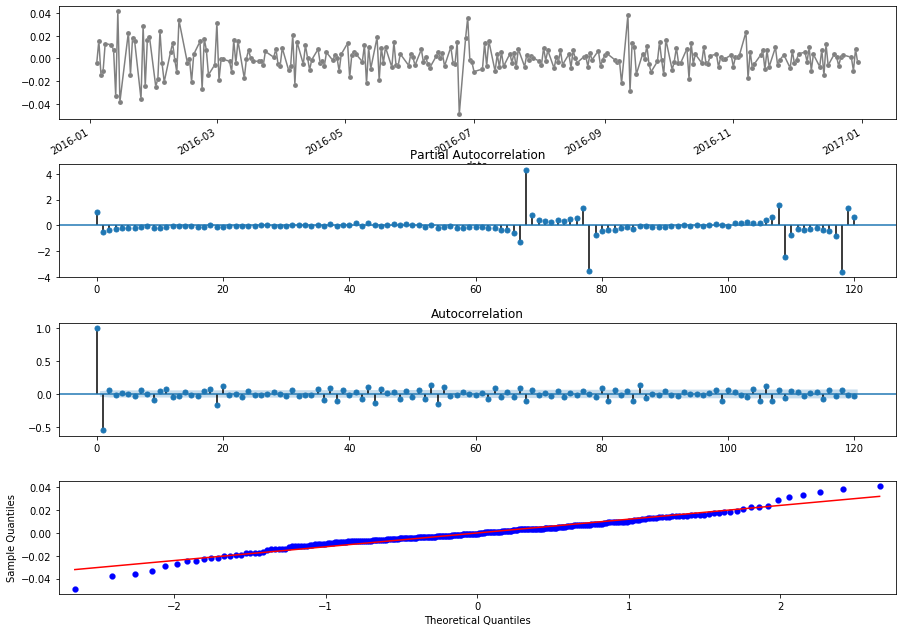

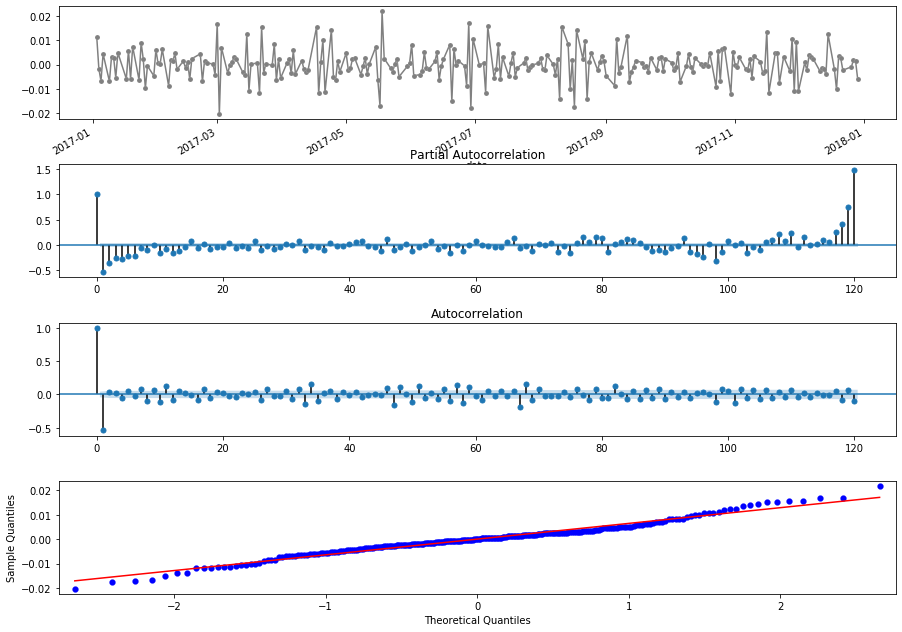

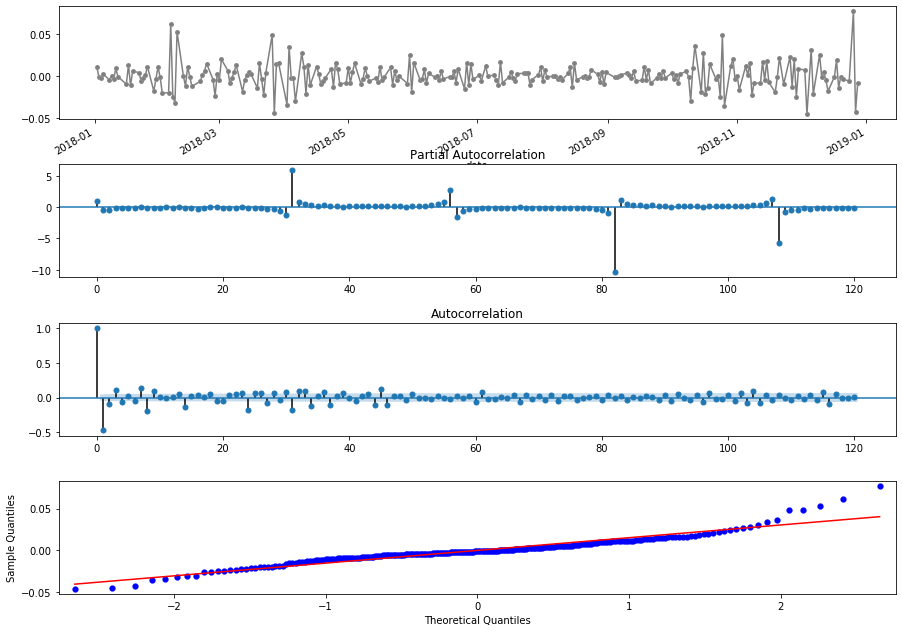

In [10]:
def plot_pacf_acf(R0,lag0,alpha0):
    fig,(ax3,ax4,ax5,ax6) = plt.subplots(figsize=(15,12),nrows=4)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    R0.plot(ax=ax3, marker='o', c='gray', ms=5.,markeredgecolor='white', markeredgewidth=.1)   
    tsp.plot_pacf(R0,alpha=alpha0,lags=lag0,ax=ax4)
    tsp.plot_acf(R0,alpha=alpha0,lags=lag0,ax=ax5)
    sm.qqplot(R0, line='s', marker='o',markeredgewidth=0.2,ax=ax6)

for year in R['year'].unique()[1:]:    
    plot_pacf_acf(R[R['year']==year]['SPY'], lag0=120, alpha0=0.5)

### Although we have used the differencing methods we can see that PACF and ACF for each year are having dependencies (showing the underlying correlation in the data) 

### As a solution, testing the train and test splits in the dataset for checking the ideal split where test and train splits are both from the same data distribution  

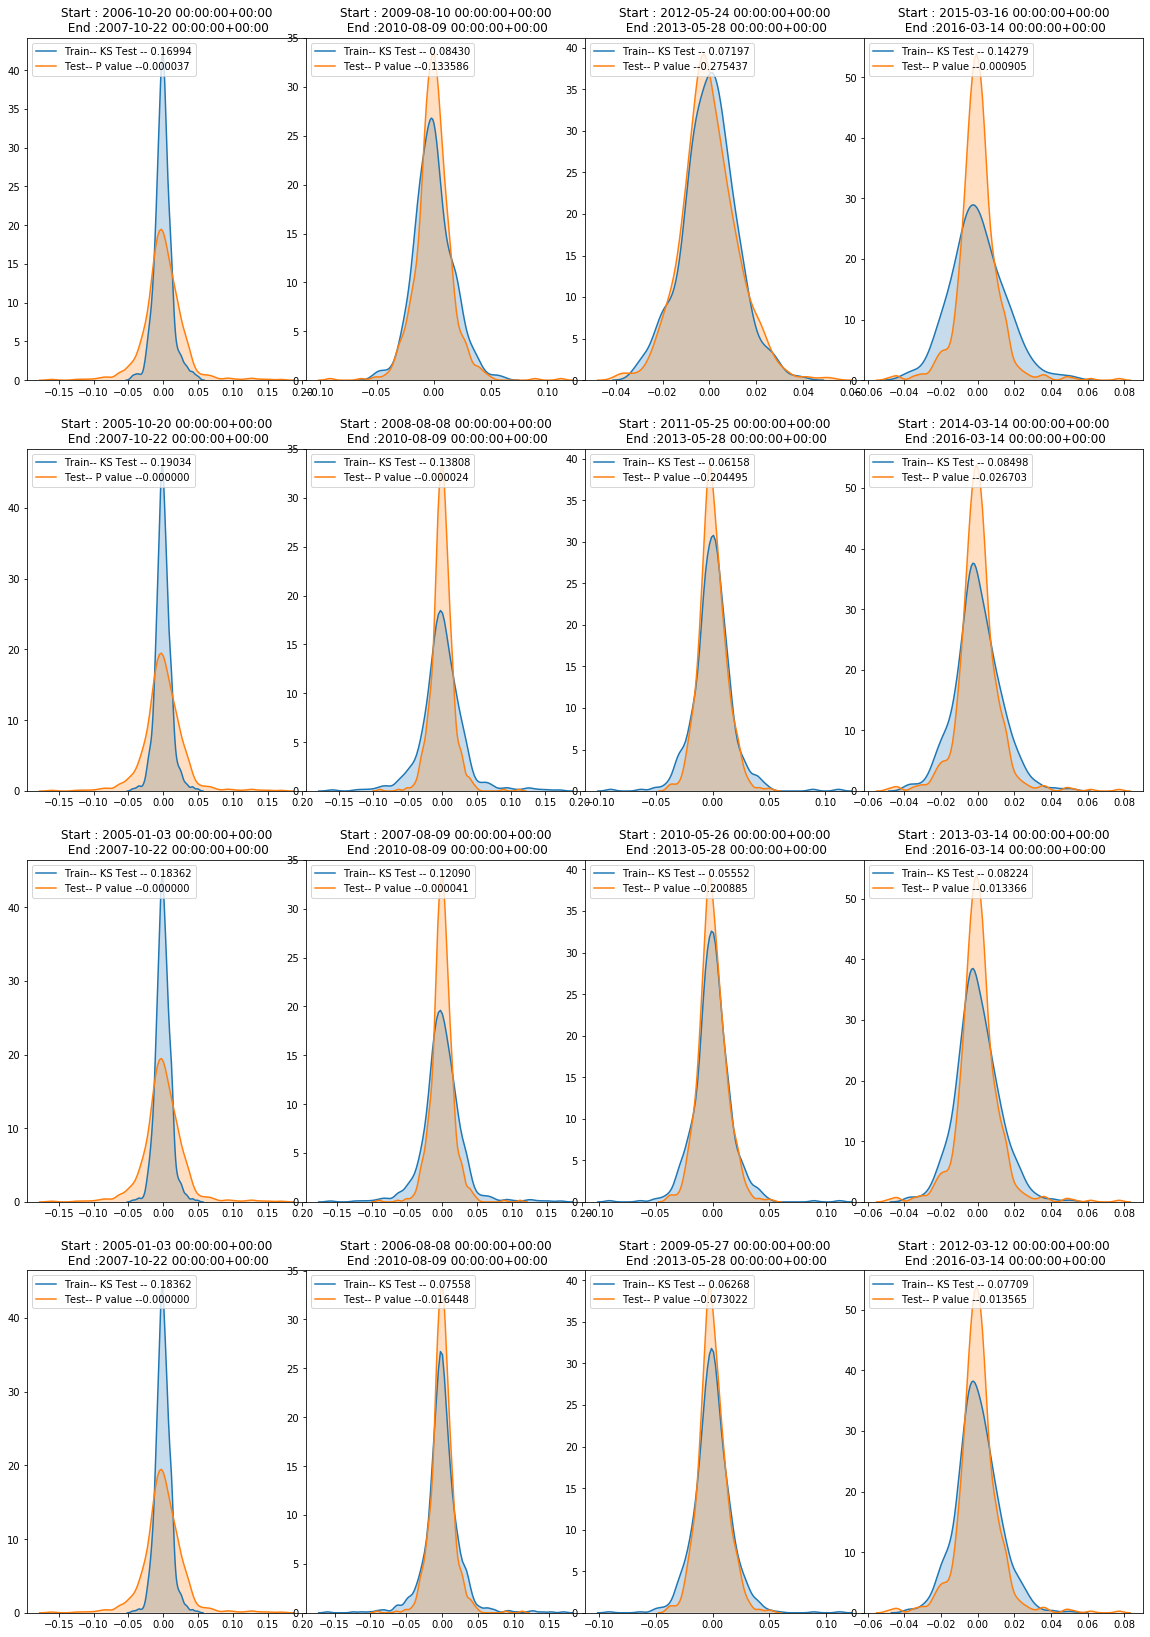

In [11]:
train_size = [252, 252*2, 252*3, 252*4] ##252 = Busi Days in one year
folds = 4
Rdata = R['SPY']['2005':]

gs = gridspec.GridSpec(folds, len(train_size), wspace=0.0)

fig = plt.figure(figsize=(20,25))

i = 0
dataRaw = []

for size in train_size:
    tsobj = TimeSeriesSplit(n_splits=folds, max_train_size=size)
    j = 0
        
    for train_index, test_index in tsobj.split(Rdata):
        
        Rdata_train = Rdata[train_index] 
        Rdata_test = Rdata[test_index]
        
        score,p = ks_2samp(Rdata_train, Rdata_test)
        ax1 = plt.subplot(gs[i,j])
        
        sns.kdeplot(Rdata_train,shade=True,label=str('Train') + '-- KS Test -- ' + str('%.5f'%score),ax=ax1)
        sns.kdeplot(Rdata_test,shade=True,label=str('Test') + '-- P value --' + str('%.6f'%p),ax=ax1)
        plt.title('Start : ' + str(Rdata_train.index[0]) + '\n End :' + str(Rdata_train.index[-1]))
        plt.legend(loc='upper left')
        plt.subplots_adjust(top=1.00)
        
        j = j + 1
        
        
        row = (size, score, p , Rdata_train.index[0],Rdata_train.index[-1],Rdata_test.index[0],Rdata_test.index[-1])
        dataRaw.append(row)

 
    i = i + 1
    
    

In [12]:
columns = ['train_size','KS','p-value','train_startD','train_endD','test_startD','test_endD']
dataSplits = pd.DataFrame(dataRaw, columns = columns)

In [13]:
pThreshold = 0.01
dataSplitAcpt = dataSplits[dataSplits['p-value']<pThreshold]

len(dataSplitAcpt)/len(dataSplits)

0.4375

### The percentage of Train/Test splits which accept the null hypothesis that Test and Train came from the same distribution is 43% for p value of 0.01

2006-10-20 00:00:00+00:00 to 
2010-08-09 00:00:00+00:00
2015-03-16 00:00:00+00:00 to 
2018-12-28 00:00:00+00:00
2005-10-20 00:00:00+00:00 to 
2010-08-09 00:00:00+00:00
2008-08-08 00:00:00+00:00 to 
2013-05-28 00:00:00+00:00
2005-01-03 00:00:00+00:00 to 
2010-08-09 00:00:00+00:00
2007-08-09 00:00:00+00:00 to 
2013-05-28 00:00:00+00:00
2005-01-03 00:00:00+00:00 to 
2010-08-09 00:00:00+00:00


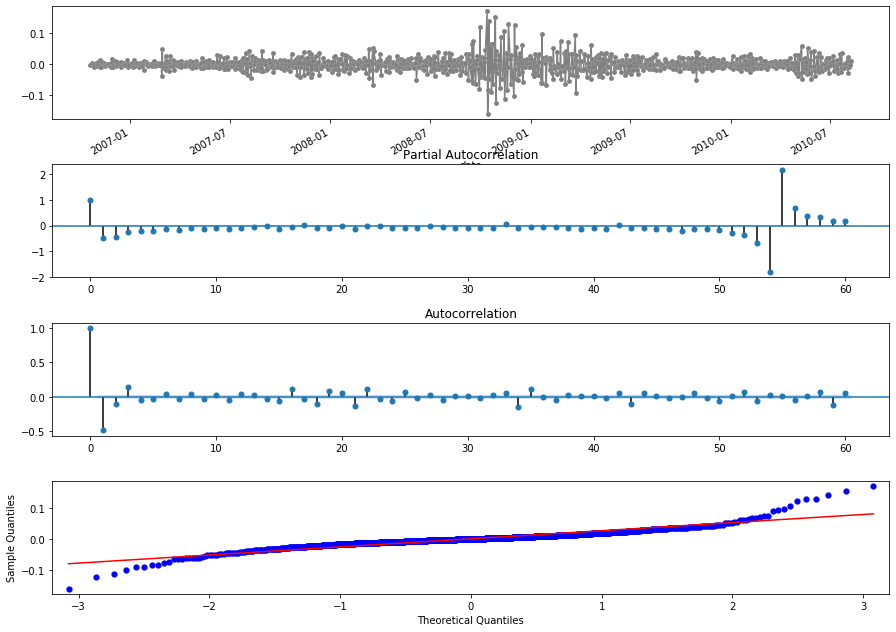

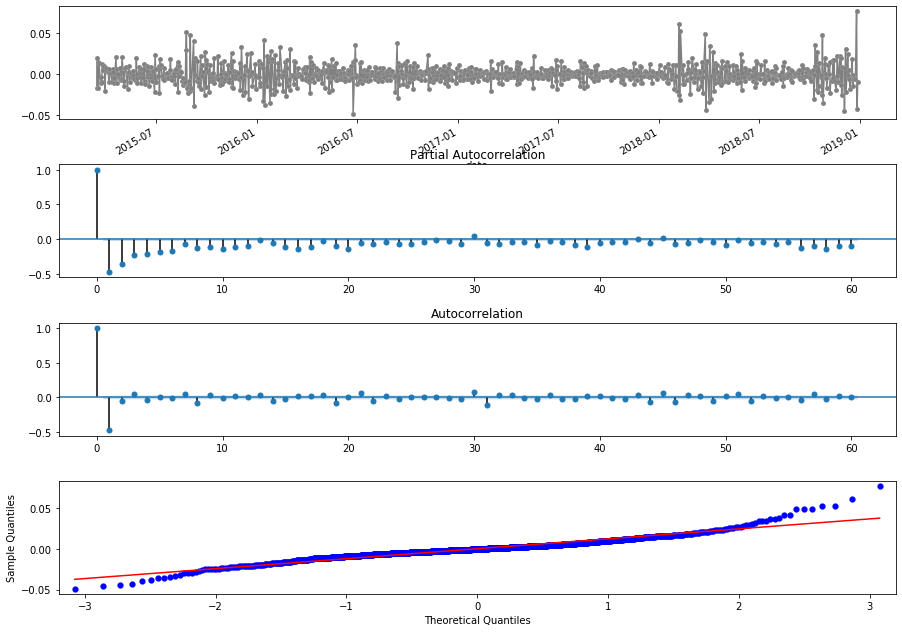

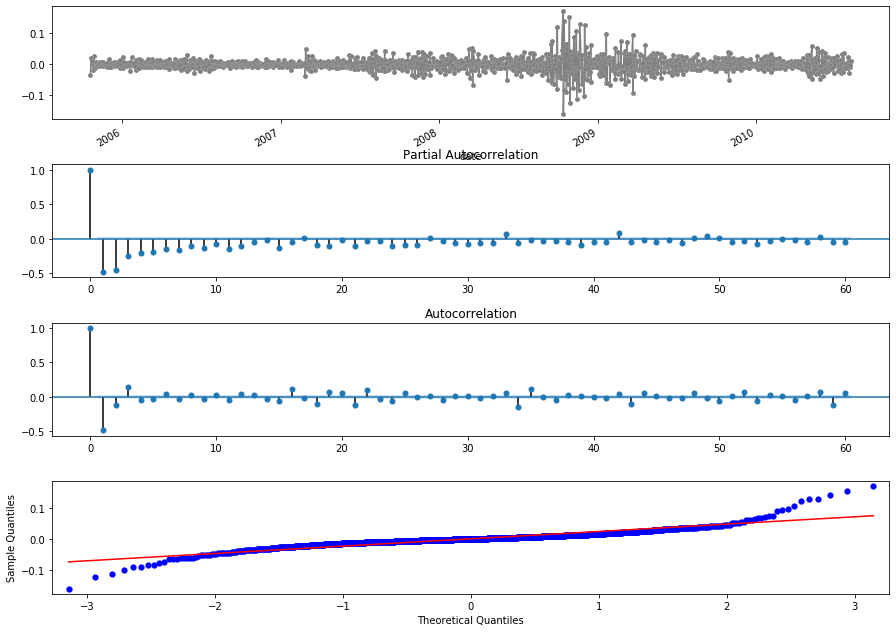

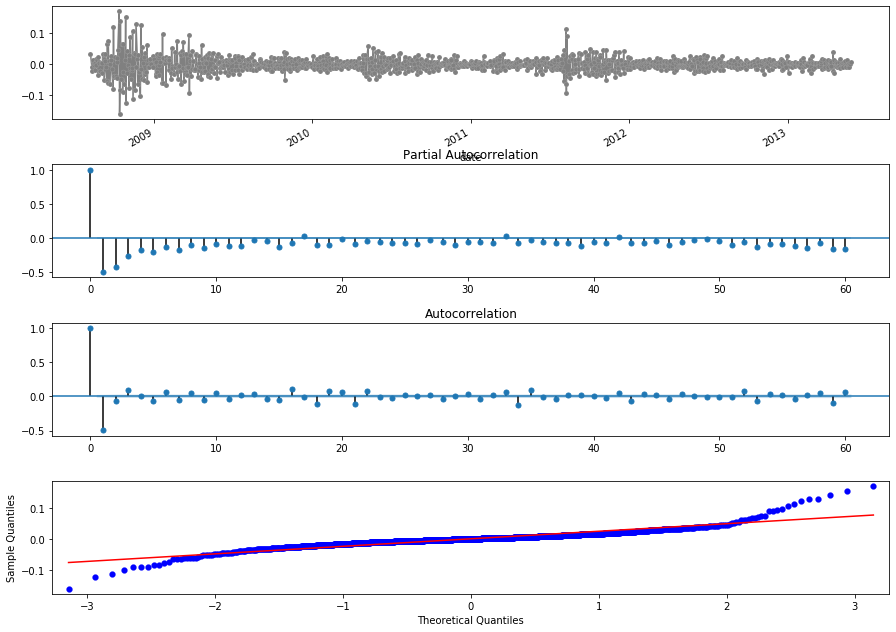

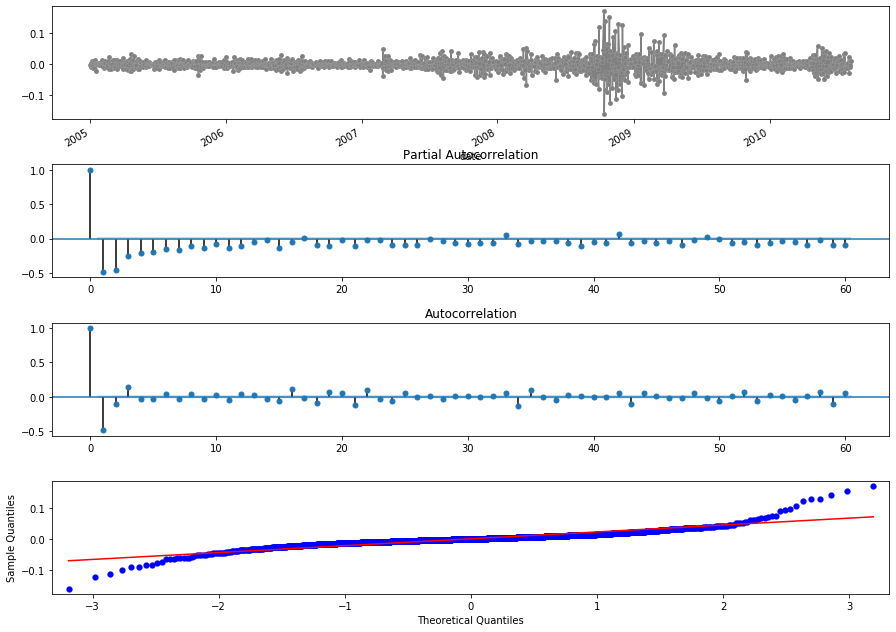

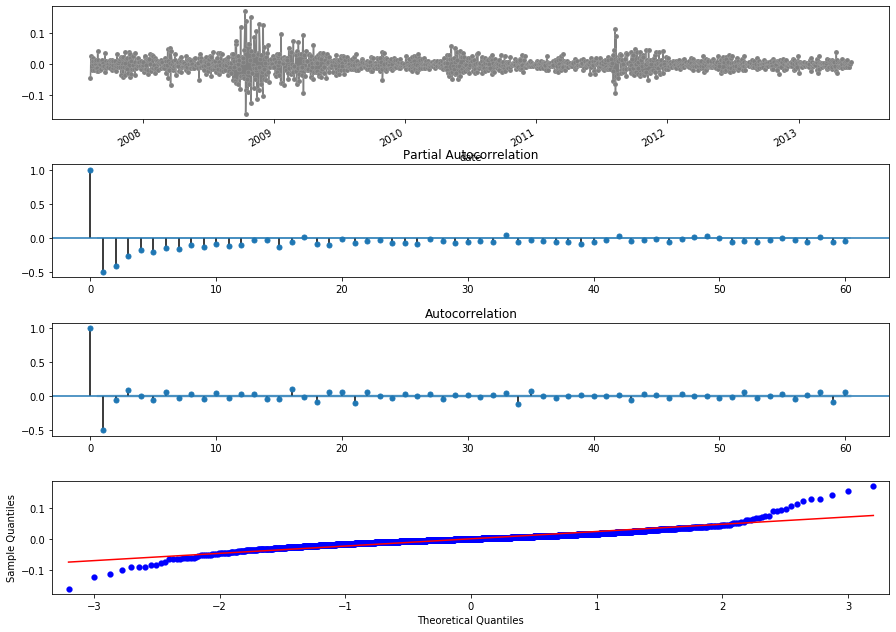

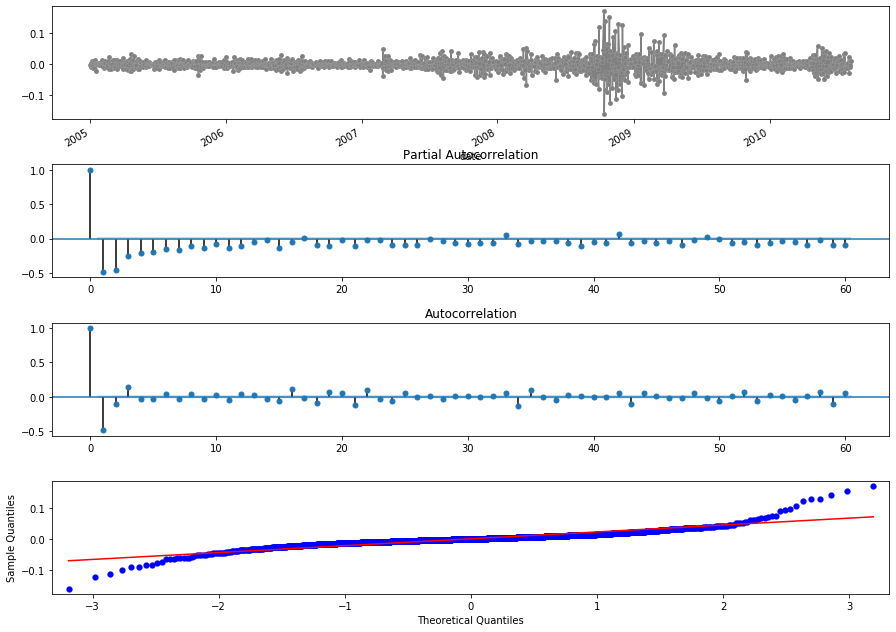

In [14]:
for i,row in dataSplitAcpt.iterrows():
    print(str(row['train_startD']) + ' to ')
    plot_pacf_acf(R['SPY'][pd.to_datetime(row['train_startD']) : pd.to_datetime(row['test_endD'])],lag0=60, alpha0=0.5)
    print(str(row['test_endD']))

### The data comes from different distributions, from different market segments over the years. Thus, understanding the underlying distributions in the data for better predictions of the returns and drawdowns from the individual clustered normal distributions

### Now applying the Gaussian Mixture Models for cluster estimation on the SPY data
####    1. The GMM uses unsupervised approach to cluster the data. We first try to understand the optimal number of components ( different distribution to assume in the Joint distribution of data)
####    2. AIC and BIC referenced to Akaike Information Criterion and the Bayesian Information Criterion are used to compare the results of 2 or models based on the overfitting nature of the model. The penalty is baed on the number of parameters (Components used in model) used for the model training phase 

In [15]:
CpyRdata = Rdata
CpyRdata.describe()


count    3.522000e+03
mean     2.431704e-07
std      1.728798e-02
min     -1.599979e-01
25%     -7.401844e-03
50%     -6.148378e-04
75%      7.174015e-03
max      1.694535e-01
Name: SPY, dtype: float64

In [16]:
nCpyRdata = np.asarray(CpyRdata) 
nCpyRdata = nCpyRdata.reshape(-1,1)

-------------------------
means: [ 1.58618572e-02 -3.50963053e-02 -7.78073359e-05 -1.32064659e-02
  5.73884314e-02]
-------------------------
covars: [1.38116837e-04 1.03284910e-03 4.95331037e-05 1.03098115e-04
 1.97048210e-03]
-------------------------
sqrt covar: [0.01175231 0.03213797 0.00703798 0.01015372 0.04439011]
-------------------------
aic: -19858.42981
bic: -19772.09483
-------------------------


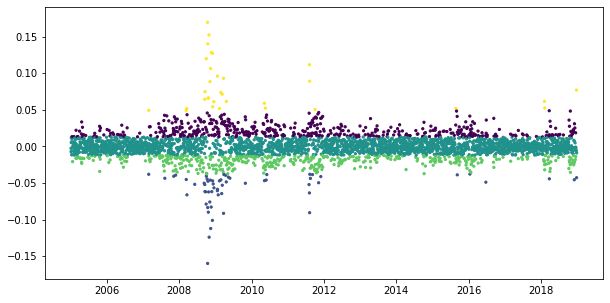

In [17]:
def create_gmm(n_components, max_iter, R):
    
    GMM = mxt.GaussianMixture(n_components, covariance_type='full', random_state=R, tol=0.001, 
                              reg_covar=1e-06, max_iter=max_iter, n_init=1)
    return GMM

def print_gmm_results(gmm, X):
    print('-'*25)
    print(f'means: {gmm.means_.ravel()}')
    print('-'*25)
    print(f'covars: {gmm.covariances_.ravel()}')
    print('-'*25)
    print(f'sqrt covar: {np.sqrt(gmm.covariances_.ravel())}')
    print('-'*25)
    print(f'aic: {gmm.aic(X):.5f}')
    print(f'bic: {gmm.bic(X):.5f}')
    print('-'*25)

GMM = create_gmm(5,150,0)
GMM = GMM.fit(nCpyRdata)
print_gmm_results(GMM, nCpyRdata)

labels = GMM.predict(nCpyRdata)
fig = plt.figure(figsize=(10,5))
plt.scatter(CpyRdata.index, nCpyRdata[:, 0], c=labels, s=5, cmap='viridis');


In [18]:

def plotAICBIC(X, minComponents, maxComponents):

    dataRaw = []
    for i in range(minComponents, maxComponents):

        GMM = create_gmm(i,150,0)
        GMM = GMM.fit(nCpyRdata)
        row = (i, GMM.aic(X), GMM.bic(X))
        dataRaw.append(row)
    
    columns = ['index','AIC','BIC']
    AicDf = pd.DataFrame(dataRaw, columns = columns)    
    AicDf = AicDf.set_index('index')
    
    fig = plt.figure(figsize=(10,5))

    sns.lineplot(data=AicDf)
    
    aicMinIn = AicDf[AicDf['AIC']==AicDf['AIC'].min()].index
    bicMinIn = AicDf[AicDf['BIC']==AicDf['BIC'].min()].index
    
    plt.axvline(aicMinIn, color='blue',label='Min AIC = ' + str(aicMinIn))
    plt.axvline(bicMinIn, color='red',label='Min BIC = ' + str(bicMinIn))
    plt.legend(ncol=2, loc='upper left')
    
    
    return AicDf
    

,AIC,BIC
index,,
2,-19755.111561,-19724.277639
3,-19804.226956,-19754.892682
4,-19834.256029,-19766.421402
5,-19858.429813,-19772.094833
6,-19862.710642,-19757.875309
7,-19875.141010,-19751.805324
8,-19866.748205,-19724.912166
9,-19864.006011,-19703.669620
10,-19858.992880,-19680.156136


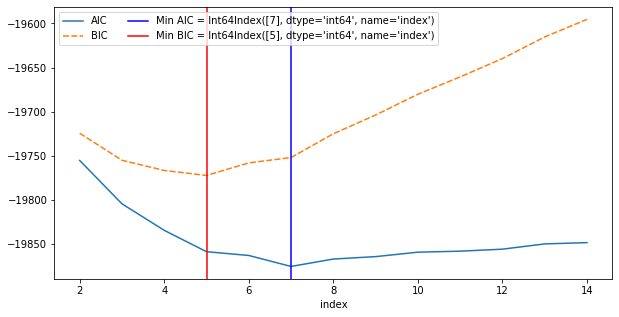

In [19]:
plotAICBIC(nCpyRdata, 2, 15)

#### We can not understand the ideal number of components to have in the GMM model with AIC and BIC values. BIC penalizes the components heavily for increase in components. The ideal number given by the pair is 5 for the entire training dataset (2005 - 2018)  

#### The scope of GMM is as follows:
    1. Identify the different distributions and tracing if a stable distribution for the pair of test/train datasets can be used to predict the future values of returns
    2. Based on the distribution, taking risk based decisions to reduce the market position for the stock 
    3. Set trading filters based on the position, price and returns
    

In [20]:
maxSiz = 252
folds = len(Rdata) - 1 
tsobj = TimeSeriesSplit(n_splits=folds, max_train_size=maxSiz)
j = 0
k = 0

RawRow = []
pred_df_all = []
sym = 'SPY'


for train_index, test_index in tsobj.split(Rdata):
        if k < 252:
            k = k + 1
            continue

        Rdata_train = Rdata[train_index] 
        Rdata_test = Rdata[test_index]
#         print(Rdata_test[0])
#         print('--------')
#         X_test = Rdata.iloc[test_index].values.reshape(1, -1)
#         print(X_test.ravel()[0])
        nCpyRdata = np.asarray(Rdata_train) 
        nCpyRdata = nCpyRdata.reshape(-1,1)

        nCpyRdataTest = np.asarray(Rdata_test) 
        nCpyRdataTest = nCpyRdataTest.reshape(-1,1)
        
        GMM = create_gmm(3,150,0)
        GMM = GMM.fit(nCpyRdata)
        
        all_prob = GMM.predict_proba(nCpyRdata)
        
        state_prob = pd.DataFrame(all_prob,
                            columns=['s1','s2','s3'],index=Rdata.iloc[train_index].index)

        state_df = Rdata.iloc[train_index].to_frame()
        hs_prob_df = (pd.concat([state_df,
                                 state_prob],axis=1))
        
        # get state probability means and stds
        s1_mu = hs_prob_df.query('abs(s1)>0.5')[sym].mean() 
        s2_mu = hs_prob_df.query('abs(s2)>0.5')[sym].mean() 
        s3_mu = hs_prob_df.query('abs(s3)>0.5')[sym].mean() 
#         s4_mu = hs_prob_df.query('abs(s4)>0.5')[sym].mean() 
#         s5_mu = hs_prob_df.query('abs(s5)>0.5')[sym].mean() 

        
        ## Working Code 
        
        pred_label = GMM.predict(nCpyRdata)
        last_label = pred_label[-1]
        last_prob = all_prob[-1][last_label]
        pred_var = GMM.covariances_.ravel()[last_label]
        pred_mean = GMM.means_.ravel()[last_label]
        
        rvs = scpSta.norm.rvs(loc=pred_mean,scale=np.sqrt(pred_var),size=1000)
        lower_i,upper_i = scpSta.norm.interval(0.95, loc=np.mean(rvs), scale=np.std(rvs))
        row = Rdata_test.index[0], last_label, Rdata_test[0], pred_var, pred_mean, upper_i, lower_i, last_prob, s1_mu, s2_mu, s3_mu 
                
        ### Last step
        RawRow.append(row)

cols = ['Date','pred_label', 'Actual Return','pred_class_variance','pred_class_mean','upper_i','lower_i','last_prob','class_0_mean','class_1_mean'
       ,'class_2_mean']

pred_df_all = pd.DataFrame(RawRow,columns=cols)
        
pred_df_all

,Date,pred_label,Actual Return,pred_class_variance,pred_class_mean,upper_i,lower_i,last_prob,class_0_mean,class_1_mean,class_2_mean
0,2006-01-04 00:00:00+00:00,0,-0.012853,0.000073,0.007312,0.024470,-0.010075,0.997415,0.011017,-0.017445,-0.003133
1,2006-01-05 00:00:00+00:00,0,-0.004107,0.000060,-0.007902,0.007707,-0.023247,0.798634,-0.012162,0.018242,0.002220
2,2006-01-06 00:00:00+00:00,0,0.007693,0.000045,0.001143,0.014520,-0.011891,0.585945,0.001860,-0.012541,0.018242
3,2006-01-09 00:00:00+00:00,2,-0.005752,0.000045,0.001261,0.014432,-0.012252,0.687867,-0.012541,0.018775,0.002220
4,2006-01-10 00:00:00+00:00,2,-0.001560,0.000045,0.001294,0.014173,-0.011907,0.513280,-0.012348,0.018775,0.002274
...,...,...,...,...,...,...,...,...,...,...,...
3264,2018-12-21 00:00:00+00:00,2,-0.004091,0.000053,-0.000374,0.014689,-0.014480,0.884000,0.025151,-0.025710,-0.000471
3265,2018-12-24 00:00:00+00:00,1,-0.006054,0.000052,-0.000475,0.013996,-0.014330,0.869080,-0.025710,-0.000583,0.025151
3266,2018-12-26 00:00:00+00:00,2,0.076948,0.000052,-0.000580,0.012863,-0.014256,0.847191,0.024434,-0.025710,-0.000777
3267,2018-12-27 00:00:00+00:00,2,-0.042848,0.000548,0.019626,0.065748,-0.025705,1.000000,0.000577,-0.025344,0.038466


In [21]:
def CI_function(df):
    filt = (df['lower_i'] < df['Actual Return']) & (df['Actual Return'] < df['upper_i'])
    df['in_range'] = filt
    return df

def outlier_direction(df):
    filt = (df['Actual Return'] > df['upper_i'])
    df['too_high'] = filt
    return df

def labelBuy(df, thres):
    filt = (df['too_high'] == False) & (df['in_range'] == True) & (df['last_prob'] > thres) 
    df['purchase'] =filt
    return df

pred_test = pred_df_all.pipe(CI_function).pipe(outlier_direction).pipe(labelBuy, thres=0.5)

pred_test.set_index(pred_test.Date,inplace=True)

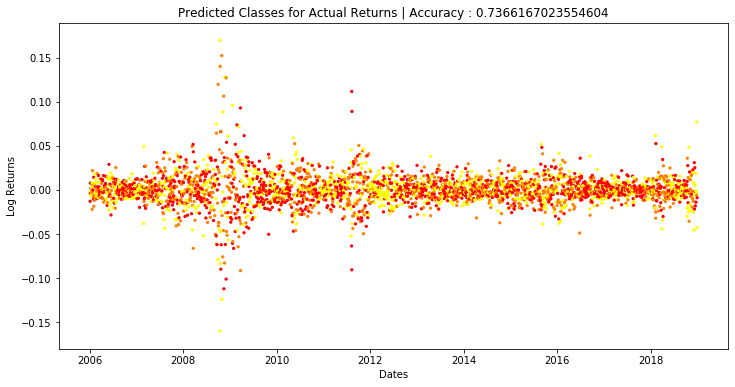

In [22]:
def predPlot(df):
    accu = len(df[df['in_range'] == True])/ len(df)
    fig = plt.figure(figsize=(12,6))
    plt.scatter(df.index, df['Actual Return'], c=df.pred_label, s=5, cmap='autumn', label='Accuracy : ' + str(accu))
    plt.title('Predicted Classes for Actual Returns' + ' | Accuracy : ' + str(accu))
    plt.xlabel('Dates')
    plt.ylabel('Log Returns')
predPlot(pred_test)

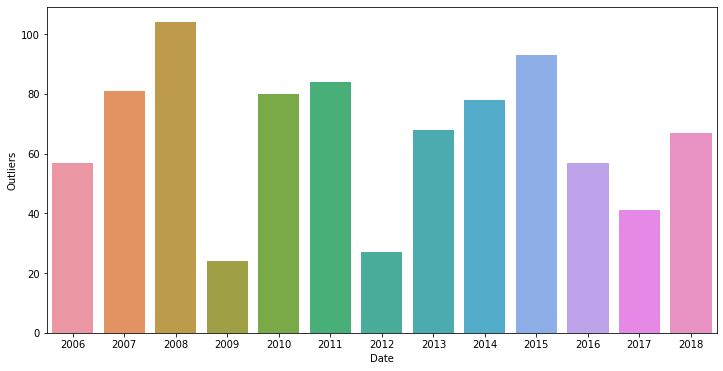

In [23]:
def plotOut(pred_test,F):
    grp = pred_test.groupby([pd.Grouper(freq=F)])['in_range'] 
    outlierDf = (grp.count()-grp.sum()).reset_index()

    fig = plt.figure(figsize=(12,6))

    if F=='Y':
        outlierDf.Date = outlierDf['Date'].dt.year
    else:
        outlierDf.Date = outlierDf['Date'].dt.to_period('M')
    
    outlierDf.set_index(outlierDf.Date,inplace=True)
    outlierDf.rename(columns={'Date':F,'in_range':'Outliers'},inplace=True)
    sns.barplot(outlierDf.index,outlierDf.Outliers)
#     sns.set_xticklabels(outlierDf.index.df.year)
plotOut(pred_test,'Y')

### Event Study #### 

#### Understanding the behaviour around the prediction column for 'Buy/Sell'
    1. To test the whether for a given time T, the column prediction of 'Buy' is accurate we will plot the returns over the period of T-N and T+N. 
    2. If there is significant increase in returns after the event (T) then we can assume that the predcition for 'Buy' has some weight to it. 
    
    https://www.quantopian.com/posts/research-looking-for-drift-an-event-study-with-share-buybacks-announcements


In [24]:
len(pred_test[pred_test['purchase']==True])/len(pred_test)

0.7234628326705415

In [73]:
actualAmt = prices_df['SPY']
predAll = pd.merge(actualAmt, pred_test, left_index=True, right_index=True)
predAll

,SPY,Date,pred_label,Actual Return,pred_class_variance,pred_class_mean,upper_i,lower_i,last_prob,class_0_mean,class_1_mean,class_2_mean,in_range,too_high,purchase
2006-01-04 00:00:00+00:00,94.101508,2006-01-04 00:00:00+00:00,0,-0.012853,0.000073,0.007312,0.024470,-0.010075,0.997415,0.011017,-0.017445,-0.003133,False,False,False
2006-01-05 00:00:00+00:00,94.160640,2006-01-05 00:00:00+00:00,0,-0.004107,0.000060,-0.007902,0.007707,-0.023247,0.798634,-0.012162,0.018242,0.002220,True,False,True
2006-01-06 00:00:00+00:00,94.944207,2006-01-06 00:00:00+00:00,0,0.007693,0.000045,0.001143,0.014520,-0.011891,0.585945,0.001860,-0.012541,0.018242,True,False,True
2006-01-09 00:00:00+00:00,95.188148,2006-01-09 00:00:00+00:00,2,-0.005752,0.000045,0.001261,0.014432,-0.012252,0.687867,-0.012541,0.018775,0.002220,True,False,True
2006-01-10 00:00:00+00:00,95.284238,2006-01-10 00:00:00+00:00,2,-0.001560,0.000045,0.001294,0.014173,-0.011907,0.513280,-0.012348,0.018775,0.002274,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21 00:00:00+00:00,231.818531,2018-12-21 00:00:00+00:00,2,-0.004091,0.000053,-0.000374,0.014689,-0.014480,0.884000,0.025151,-0.025710,-0.000471,True,False,True
2018-12-24 00:00:00+00:00,225.693205,2018-12-24 00:00:00+00:00,1,-0.006054,0.000052,-0.000475,0.013996,-0.014330,0.869080,-0.025710,-0.000583,0.025151,True,False,True
2018-12-26 00:00:00+00:00,237.096327,2018-12-26 00:00:00+00:00,2,0.076948,0.000052,-0.000580,0.012863,-0.014256,0.847191,0.024434,-0.025710,-0.000777,False,True,False
2018-12-27 00:00:00+00:00,238.916589,2018-12-27 00:00:00+00:00,2,-0.042848,0.000548,0.019626,0.065748,-0.025705,1.000000,0.000577,-0.025344,0.038466,False,False,False


In [133]:
# from datetime import timedelta

# def get_series(data,  n_days, current_day):
    
#     total_date_index_length = len(data['SPY'].index)
#     #: Find the closest date to the target date
#     date_index = data['SPY'].index.searchsorted(current_day + timedelta(n_days))
#     date_index_minus = data['SPY'].index.searchsorted(current_day - timedelta(n_days))
#     #: If the closest date is too far ahead, reset to the latest date possible
#     date_index = total_date_index_length - 1 if date_index >= total_date_index_length else date_index

    
# #     SlicData = data.iloc[current_day-timedelta(n_days):current_day+timedelta(n_days),:]
# #     return SlicData.iloc[current_day-1:current_day+1,]
#     return (data['SPY'].iloc[date_index] - data['SPY'].iloc[date_index_minus])/data['SPY'].iloc[date_index_minus]


def get_close_price(data, current_date, day_number):
    #: If we're looking at day 0 just return the indexed date
#     if day_number == 0:
#         return data['SPY'].ix[current_date]
#     #: Find the close price day_number away from the current_date
#     else:
    #: If the close price is too far ahead, just get the last available
    total_date_index_length = len(data['SPY'].index)
    #: Find the closest date to the target date
    date_index = data['SPY'].index.searchsorted(current_date + timedelta(day_number))
    #: If the closest date is too far ahead, reset to the latest date possible
    date_index = total_date_index_length - 1 if date_index >= total_date_index_length else date_index
    #: Use the index to return a close price that matches
    return data['SPY'].iloc[date_index]
    
def get_first_price(data, starting_point, date):
    starting_day = date - timedelta(starting_point)
    date_index = data['SPY'].index.searchsorted(starting_day)
    return data['SPY'].iloc[date_index]

def remove_outliers(returns, num_std_devs):
    return returns[~((returns-returns.mean()).abs()>num_std_devs*returns.std())]

def get_returns(data, starting_point, date, day_num):
    #: Get stock prices
    first_price = get_first_price(data, starting_point, date)
    close_price = get_close_price(data, date, day_num)

    #: Calculate returns
    ret = (close_price - first_price)/(first_price + 0.0)
    return ret


In [134]:
def run_event_study(predAll, starting_point=30):
    """
    fn: wrapper for event study computations
    
    Params
    ------
        pred_df: pd.DataFrame with prediction data in it
        starting_point: int(), days to lookbackward and forward from event
    
    Returns
    -------
        all_returns: pd.Series
        all_std_devs: pd.Series
        N: int, number of samples
        all_returns_df: pd.DataFrame, all return series bundled
    """
    data = predAll.query('purchase==True').copy()
    #: Dictionaries that I'm going to be storing calculated data in 
    all_returns = {}
    all_std_devs = {}
    total_sample_size = {}

    #: Create our range of day_numbers that will be used to calculate returns
    #: Looking from -starting_point till +starting_point which creates our timeframe band
    day_numbers = [i for i in range(-starting_point, starting_point)]

    all_return_series = []

    for day_num in day_numbers:

        #: Reset our returns and sample size each iteration
        returns = []
        sample_size = 0

        #: Get the return compared to t=0 
        #for date, row in ev_data.iterrows():
        for row in data.itertuples():
            date = row.Index
            #sid = row.symbol

            #: Make sure that data exists for the dates
            #if date not in data['close_price'].index or sid not in data['close_price'].columns:
            #    continue

            returns.append(get_returns(data, starting_point, date, day_num))
            sample_size += 1

        #: Drop any Nans, remove outliers, find outliers and aggregate returns and std dev
        returns = pd.Series(returns).dropna()
        all_return_series.append(returns)
        all_returns[day_num] = np.average(returns)
        all_std_devs[day_num] = np.std(returns)
        total_sample_size[day_num] = sample_size

    #: Take all the returns, stds, and sample sizes that I got and put that into a Series
    all_returns = pd.Series(all_returns)
    all_std_devs = pd.Series(all_std_devs)
    N = np.average(pd.Series(total_sample_size))
    ## combine all return series into dataframe
    all_returns_df = pd.DataFrame(all_return_series, index=day_numbers)
    return all_returns, all_std_devs, N, all_returns_df

In [135]:
all_returns, all_std_devs, N, all_returns_df = run_event_study(predAll, starting_point=30)

In [141]:
def plot_mean_event_returns(all_returns, thres, starting_point=30):
    day_numbers = [i for i in range(-starting_point, starting_point)]
    xticks = [d for d in day_numbers if d%2 == 0]

    f, ax=plt.subplots(figsize=(12,7))
    (all_returns-all_returns.loc[0]).plot(xticks=xticks, ax=ax, 
                                          label=f"$N={N}$", legend=True)

    plt.axhline(0, ls='--', color='red')    
    plt.axvline(0, ls='--', color='red')
    plt.grid(b=None, which=u'major', axis=u'y')
    plt.title(f"Cumulative Return from buy signals given state prob. > ${thres}$")
    plt.xlabel("Window Length (t)")
    plt.legend()
    plt.ylabel("Cumulative Return ($r$)");
    
def plot_event_returns_all_paths(all_returns_df, thres, starting_point=30):
    day_numbers = [i for i in range(-starting_point, starting_point)]
    xticks = [d for d in day_numbers if d%2 == 0]

    f, ax = plt.subplots(figsize=(12,7))

    (all_returns_df-all_returns_df.mean(axis=1).loc[0]).plot(
        xticks=xticks, ax=ax, color='xkcd:light gray', legend=False, alpha=0.1)
    (all_returns_df.mean(axis=1)-all_returns_df.mean(axis=1).loc[0]).plot(
        xticks=xticks, ax=ax, color='xkcd:midnight blue', linewidth=3,
        label=f"$N={N}$", legend=True)
    ax.set_xlim(-starting_point, starting_point)
    ax.axhline(0, ls='--', color='red')
    ax.axvline(0, ls='--', color='red')
    plt.grid(b=None, which=u'major', axis=u'y')
    plt.title(f"Cumulative Return from buy signals given state prob. > ${thres}$ (all paths)")
    plt.xlabel("Window Length (t)")
    plt.ylabel("Cumulative Return (r)");
        

def plot_event_sharpe_estimate(all_returns,all_std_devs, thres, starting_point=30):
    day_numbers = [i for i in range(-starting_point, starting_point)]
    xticks = [d for d in day_numbers if d%2 == 0]

    f, ax=plt.subplots(figsize=(12,7))

    mod_sharpe = ((all_returns-all_returns.loc[0]) / all_std_devs)
    mod_sharpe.plot(xticks=xticks, ax=ax, label=f"$N={N}$", legend=True)

    #ax.axvline(mod_sharpe.idxmax(), ls='--', color=blue)    
    plt.axvline(0, ls='--', color='red')
    plt.axhline(0, ls='--', color='red')
    plt.grid(b=None, which=u'major', axis=u'y')
    plt.title(f"Sharpe estimate from buy signals with state prob. > ${thres}$")
    plt.xlabel("Window Length (t)")
    plt.legend()
    plt.ylabel("Sharpe Ratio ($\mu / \sigma$)");
    print(f'state prob. > ${thres}$ max sharpe ratio: {mod_sharpe.max():.3} at {mod_sharpe.idxmax()} days')
    
def plot_event_density(all_returns_df, thres):
    (pn.ggplot(pd.melt(all_returns_df).dropna(), pn.aes(x='value'))
     +pn.geom_density(pn.aes(y='..density..'))
     +pn.geom_histogram(pn.aes(y='..density..', bins=10), alpha=0.2)
     + pn.theme(axis_text_x=pn.element_text(rotation=50),
                text=pn.element_text(size=7), figure_size=(9,6))      
     + pn.ggtitle(f'Event study density with state prob. > ${thres}$')).draw();        

state prob. > $0.5$ max sharpe ratio: 0.132 at 29 days


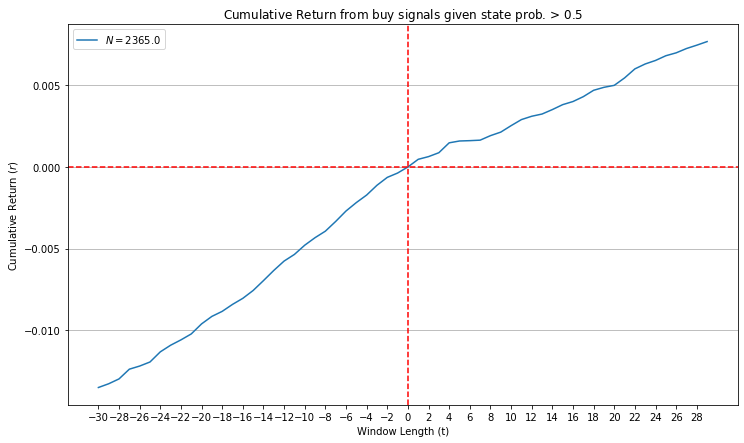

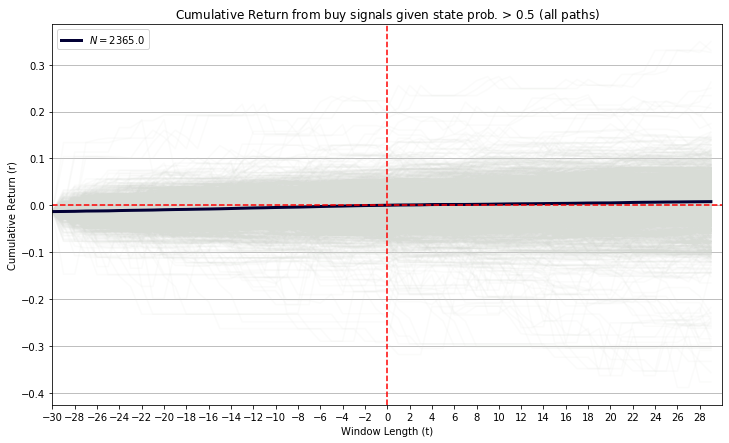

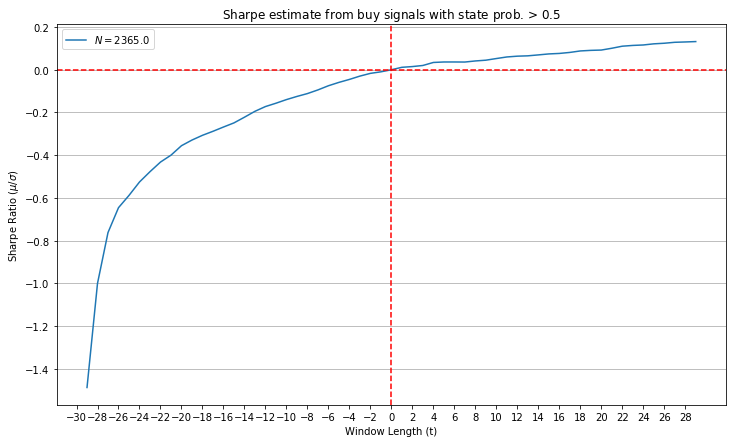

In [143]:
THRES = 0.5
plot_mean_event_returns(all_returns, thres=THRES)
plot_event_returns_all_paths(all_returns_df, thres=THRES)    
plot_event_sharpe_estimate(all_returns, all_std_devs, thres=THRES)    


#### The analysis of the graphs show that our event is at '0' index. 
    1.When the state probability is > 0.5 we can see that there is 5% returns in the next 30 days for all 'Purchase = True' predictions
    2. For all of the observations the plot is flatter in comparison
    3. Sharpe ration gives the understanding of returns given the voaltility involed. As we can see the sharpe ratio enters value range (-1.4, 0 ) till the event and then for the next 30 days it reaches the safe +0.16 

In [149]:
allStatus = ffn.calc_stats(predAll['SPY'])

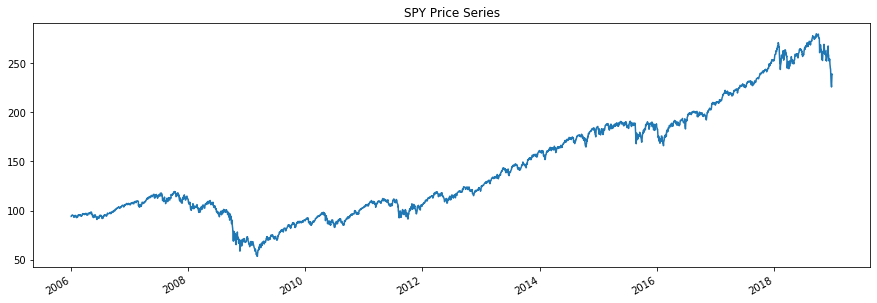

In [151]:
allStatus.plot()